In [3]:
import sys
sys.path.insert(0, '/users/ankushroy/iris/src')
print(sys.path)

['/users/ankushroy/iris/src', '/users/ankushroy/iris/src', '/users/ankushroy/iris/src/models/tokenizer', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python38.zip', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/lib-dynload', '', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages']


In [4]:
from dataclasses import dataclass
from typing import Any, Tuple

from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses

batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor

#The Tokenizer Class

class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of reshaped z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [5]:
from typing import List

import torch
import torch.nn as nn
## Configuration files 
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [6]:
encoder = Encoder(EncoderDecoderConfig(resolution=28,
                                       in_channels=1
                                       ,
                                        z_channels=128,
                                        ch=64,
                                        ch_mult= [1,1,1],
                                        num_res_blocks= 2,
                                        attn_resolutions= [7, 14],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=28,
                                       in_channels=1,
                                        z_channels=128,
                                        ch=64,
                                        ch_mult= [1,1,1],
                                        num_res_blocks= 2,
                                        attn_resolutions= [7, 14],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 256 # actual vocabulary size 
embed_dim = 128 # the desired embedding dimension of the codebook 
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
print(encoder)
print(decoder)


Tokenizer : shape of latent is (128, 7, 7).
Encoder(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList()
      (dow

In [7]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [8]:
#Downloading the Dataset - FashionMNIST
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.FashionMNIST('/users/ankushroy/iris/src/models/tokenizer/FashionMNIST', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('/users/ankushroy/iris/src/models/tokenizer/FashionMNIST', download=True, train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=True)
print(len(trainloader))
print(len(testloader))


3750
625


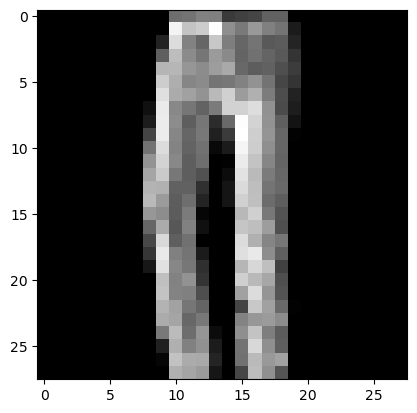

torch.Size([16, 28, 28])


In [9]:
#Visualising the images
import matplotlib.pyplot as plt

# Get one batch of images from the training loader
dataiter = iter(trainloader)
images, labels = dataiter.next()
# The images are in the shape (batch_size, 1, 28, 28). We need to reshape them to (28, 28).
images = images.reshape(-1, 28, 28)

# Display the first image in the batch
plt.imshow(images[0], cmap='gray')
plt.show()
print(images.shape)

In [ ]:
# EXPERIMENT WITH THE SIZE OF IMAGES
# import torch.nn.functional as F

# # Get one batch of images from the training loader
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # Interpolate the images to 64x64
# images_high_res = F.interpolate(images, size=(128, 128))
# images_high_res = images_high_res.reshape(-1, 128, 128)

# plt.imshow(images_high_res[0], cmap='gray')
# plt.show()

In [10]:
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:1
PyTorch version: 1.11.0


In [10]:
import numpy as np
from collections import defaultdict
from torch.cuda.amp import autocast
from torch.autograd import Variable
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=20
#device = torch.device("cuda:1")  # Specify the GPU device
device = torch.device("cuda:1")
epoch_start=0
tokenizer.to(device)
all_metrics = []
for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [4,9,19]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(trainloader):
        loss_total_step=0.0
        image = images[0]
        #image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= Variable(image).to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/16
        if (i+1) % 16 == 0:
            (loss_total_step/16).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/16
                    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save(optimizer_tokenizer.state_dict(),'/space/ankushroy/Tokeniser_FashionMNIST_1/vqvae_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_FashionMNIST_1/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary


epoch 0
Losses: Total = 0.3794
Losses: Total = 0.3416
Losses: Total = 0.4174
Losses: Total = 0.3634
Losses: Total = 0.4802
Losses: Total = 0.4251
Losses: Total = 0.3766
Losses: Total = 0.4231
Losses: Total = 0.3272
Losses: Total = 0.5355
Losses: Total = 0.4358
Losses: Total = 0.3879
Losses: Total = 0.3727
Losses: Total = 0.3608
Losses: Total = 0.3468
Losses: Total = 0.5233
Losses: Total = 0.3458
Losses: Total = 0.3813
Losses: Total = 0.4043
Losses: Total = 0.3314
Losses: Total = 0.3691
Losses: Total = 0.4523
Losses: Total = 0.5444
Losses: Total = 0.3617
Losses: Total = 0.5591
Losses: Total = 0.5574
Losses: Total = 0.3699
Losses: Total = 0.4641
Losses: Total = 0.4528
Losses: Total = 0.5150
Losses: Total = 0.3803
Losses: Total = 0.5989
Losses: Total = 0.4056
Losses: Total = 0.3432
Losses: Total = 0.3780
Losses: Total = 0.6193
Losses: Total = 0.5535
Losses: Total = 0.3114
Losses: Total = 0.3988
Losses: Total = 0.3483
Losses: Total = 0.3561
Losses: Total = 0.3427
Losses: Total = 0.5346
Los

Losses: Total = 0.3026
Losses: Total = 0.3892
Losses: Total = 0.2657
Losses: Total = 0.4720
Losses: Total = 0.2695
Losses: Total = 0.3098
Losses: Total = 0.2401
Losses: Total = 0.2136
Losses: Total = 0.4392
Losses: Total = 0.4107
Losses: Total = 0.3337
Losses: Total = 0.3038
Losses: Total = 0.3536
Losses: Total = 0.5551
Losses: Total = 0.2770
Losses: Total = 0.3350
Losses: Total = 0.4058
Losses: Total = 0.3147
Losses: Total = 0.3528
Losses: Total = 0.3023
Losses: Total = 0.3550
Losses: Total = 0.4760
Losses: Total = 0.3867
Losses: Total = 0.3407
Losses: Total = 0.3594
Losses: Total = 0.5083
Losses: Total = 0.3016
Losses: Total = 0.3316
Losses: Total = 0.3717
Losses: Total = 0.3652
Losses: Total = 0.3829
Losses: Total = 0.4028
Losses: Total = 0.2934
Losses: Total = 0.3564
Losses: Total = 0.5238
Losses: Total = 0.3947
Losses: Total = 0.2911
Losses: Total = 0.2791
Losses: Total = 0.2724
Losses: Total = 0.3676
Losses: Total = 0.5593
Losses: Total = 0.3231
Losses: Total = 0.3173
Losses: Tot

Losses: Total = 0.4611
Losses: Total = 0.2753
Losses: Total = 0.4093
Losses: Total = 0.3228
Losses: Total = 0.3477
Losses: Total = 0.2980
Losses: Total = 0.4221
Losses: Total = 0.4017
Losses: Total = 0.3336
Losses: Total = 0.3389
Losses: Total = 0.2186
Losses: Total = 0.2829
Losses: Total = 0.4085
Losses: Total = 0.3042
Losses: Total = 0.3692
Losses: Total = 0.3704
Losses: Total = 0.4874
Losses: Total = 0.4079
Losses: Total = 0.4251
Losses: Total = 0.2697
Losses: Total = 0.3854
Losses: Total = 0.3449
Losses: Total = 0.2729
Losses: Total = 0.2867
Losses: Total = 0.5323
Losses: Total = 0.3702
Losses: Total = 0.3732
Losses: Total = 0.6367
Losses: Total = 0.3623
Losses: Total = 0.3636
Losses: Total = 0.5257
Losses: Total = 0.3270
Losses: Total = 0.5659
Losses: Total = 0.2374
Losses: Total = 0.3275
Losses: Total = 0.2712
Losses: Total = 0.3330
Losses: Total = 0.2941
Losses: Total = 0.3442
Losses: Total = 0.4313
Losses: Total = 0.3025
Losses: Total = 0.4404
Losses: Total = 0.3420
Losses: Tot

Losses: Total = 0.2641
Losses: Total = 0.2329
Losses: Total = 0.4065
Losses: Total = 0.2598
Losses: Total = 0.4109
Losses: Total = 0.4452
Losses: Total = 0.2835
Losses: Total = 0.2489
Losses: Total = 0.2480
Losses: Total = 0.2339
Losses: Total = 0.2831
Losses: Total = 0.4025
Losses: Total = 0.4481
Losses: Total = 0.3262
Losses: Total = 0.2851
Losses: Total = 0.2407
Losses: Total = 0.4261
Losses: Total = 0.3543
Losses: Total = 0.4844
Losses: Total = 0.4031
Losses: Total = 0.2919
Losses: Total = 0.3711
Losses: Total = 0.3215
Losses: Total = 0.2857
Losses: Total = 0.2960
Losses: Total = 0.3435
Losses: Total = 0.4297
Losses: Total = 0.2809
Losses: Total = 0.2375
Losses: Total = 0.3396
Losses: Total = 0.2370
Losses: Total = 0.3396
Losses: Total = 0.3105
Losses: Total = 0.2362
Losses: Total = 0.4239
Losses: Total = 0.3666
Losses: Total = 0.1777
Losses: Total = 0.2861
Losses: Total = 0.3553
Losses: Total = 0.2362
Losses: Total = 0.3409
Losses: Total = 0.3145
Losses: Total = 0.3525
Losses: Tot

Losses: Total = 0.4183
Losses: Total = 0.2559
Losses: Total = 0.4427
Losses: Total = 0.2315
Losses: Total = 0.2740
Losses: Total = 0.2108
Losses: Total = 0.2049
Losses: Total = 0.3136
Losses: Total = 0.2253
Losses: Total = 0.2358
Losses: Total = 0.3118
Losses: Total = 0.2912
Losses: Total = 0.2706
Losses: Total = 0.3343
Losses: Total = 0.1915
Losses: Total = 0.2984
Losses: Total = 0.2353
Losses: Total = 0.3780
Losses: Total = 0.2108
Losses: Total = 0.2938
Losses: Total = 0.2502
Losses: Total = 0.2599
Losses: Total = 0.3643
Losses: Total = 0.2373
Losses: Total = 0.2123
Losses: Total = 0.2439
Losses: Total = 0.2570
Losses: Total = 0.2223
Losses: Total = 0.3177
Losses: Total = 0.2934
Losses: Total = 0.2920
Losses: Total = 0.1995
Losses: Total = 0.2717
Losses: Total = 0.2265
Losses: Total = 0.2737
Losses: Total = 0.3413
Losses: Total = 0.3241
Losses: Total = 0.2978
Losses: Total = 0.2729
Losses: Total = 0.2117
Losses: Total = 0.3629
Losses: Total = 0.1941
Losses: Total = 0.3800
Losses: Tot

Losses: Total = 0.2331
Losses: Total = 0.2553
Losses: Total = 0.3512
Losses: Total = 0.2411
Losses: Total = 0.2084
Losses: Total = 0.2124
Losses: Total = 0.2271
Losses: Total = 0.3051
Losses: Total = 0.2202
Losses: Total = 0.2510
Losses: Total = 0.3049
Losses: Total = 0.2574
Losses: Total = 0.3883
Losses: Total = 0.3577
Losses: Total = 0.2016
Losses: Total = 0.2408
Losses: Total = 0.2217
Losses: Total = 0.3296
Losses: Total = 0.2707
Losses: Total = 0.2957
Losses: Total = 0.2387
Losses: Total = 0.1945
Losses: Total = 0.2746
Losses: Total = 0.1774
Losses: Total = 0.2921
Losses: Total = 0.2305
Losses: Total = 0.3022
Losses: Total = 0.2705
Losses: Total = 0.3196
Losses: Total = 0.2481
Losses: Total = 0.2469
Losses: Total = 0.4367
Losses: Total = 0.2514
Losses: Total = 0.2956
Losses: Total = 0.3990
Losses: Total = 0.3552
Losses: Total = 0.2123
Losses: Total = 0.3174
Losses: Total = 0.2339
Losses: Total = 0.2841
Losses: Total = 0.2062
Losses: Total = 0.2662
Losses: Total = 0.4150
Losses: Tot

Losses: Total = 0.5290
Losses: Total = 0.2419
Losses: Total = 0.2253
Losses: Total = 0.2382
Losses: Total = 0.3333
Losses: Total = 0.3198
Losses: Total = 0.3046
Losses: Total = 0.3532
Losses: Total = 0.2740
Losses: Total = 0.1995
Losses: Total = 0.2349
Losses: Total = 0.2799
Losses: Total = 0.2124
Losses: Total = 0.2386
Losses: Total = 0.2384
Losses: Total = 0.5016
Losses: Total = 0.2414
Losses: Total = 0.5338
Losses: Total = 0.3416
Losses: Total = 0.1747
Losses: Total = 0.2483
Losses: Total = 0.2302
Losses: Total = 0.2605
Losses: Total = 0.1646
Losses: Total = 0.1874
Losses: Total = 0.4634
Losses: Total = 0.2042
Losses: Total = 0.3202
Losses: Total = 0.2561
Losses: Total = 0.2371
Losses: Total = 0.2751
Losses: Total = 0.3718
Losses: Total = 0.2586
Losses: Total = 0.2029
Losses: Total = 0.2523
Losses: Total = 0.1991
Losses: Total = 0.4151
Losses: Total = 0.1897
Losses: Total = 0.1990
Losses: Total = 0.2692
Losses: Total = 0.3183
Losses: Total = 0.2642
Losses: Total = 0.2642
Losses: Tot

Losses: Total = 0.1817
Losses: Total = 0.2172
Losses: Total = 0.3587
Losses: Total = 0.4599
Losses: Total = 0.1771
Losses: Total = 0.2648
Losses: Total = 0.2028
Losses: Total = 0.1573
Losses: Total = 0.3043
Losses: Total = 0.2416
Losses: Total = 0.3743
Losses: Total = 0.2397
Losses: Total = 0.2426
Losses: Total = 0.2554
Losses: Total = 0.1744
Losses: Total = 0.2477
Losses: Total = 0.2879
Losses: Total = 0.2566
Losses: Total = 0.3210
Losses: Total = 0.2444
Losses: Total = 0.2588
Losses: Total = 0.1774
Losses: Total = 0.2127
Losses: Total = 0.1971
Losses: Total = 0.4326
Losses: Total = 0.2560
Losses: Total = 0.2185
Losses: Total = 0.2246
Losses: Total = 0.1641
Losses: Total = 0.1513
Losses: Total = 0.2187
Losses: Total = 0.2948
Losses: Total = 0.1849
Losses: Total = 0.2110
Losses: Total = 0.2774
Losses: Total = 0.2902
Losses: Total = 0.3915
Losses: Total = 0.2001
Losses: Total = 0.2029
Losses: Total = 0.2693
Losses: Total = 0.3234
Losses: Total = 0.1788
Losses: Total = 0.2831
Losses: Tot

Losses: Total = 0.2860
Losses: Total = 0.2202
Losses: Total = 0.2479
Losses: Total = 0.3025
Losses: Total = 0.2082
Losses: Total = 0.3002
Losses: Total = 0.2767
Losses: Total = 0.2741
Losses: Total = 0.2862
Losses: Total = 0.2719
Losses: Total = 0.2315
Losses: Total = 0.2494
Losses: Total = 0.3401
Losses: Total = 0.1648
Losses: Total = 0.2660
Losses: Total = 0.3539
Losses: Total = 0.2505
Losses: Total = 0.1979
Losses: Total = 0.2061
Losses: Total = 0.2718
Losses: Total = 0.2461
Losses: Total = 0.2858
Losses: Total = 0.2260
Losses: Total = 0.2307
Losses: Total = 0.2183
Losses: Total = 0.3182
Losses: Total = 0.1322
Losses: Total = 0.3200
Losses: Total = 0.1618
Losses: Total = 0.1915
Losses: Total = 0.2320
Losses: Total = 0.1888
Losses: Total = 0.3880
Losses: Total = 0.4226
Losses: Total = 0.1286
Losses: Total = 0.2091
Losses: Total = 0.1937
Losses: Total = 0.3423
Losses: Total = 0.3581
Losses: Total = 0.2614
Losses: Total = 0.2459
Losses: Total = 0.1886
Losses: Total = 0.2079
Losses: Tot

Losses: Total = 0.2780
Losses: Total = 0.1794
Losses: Total = 0.2181
Losses: Total = 0.2643
Losses: Total = 0.2355
Losses: Total = 0.2407
Losses: Total = 0.2576
Losses: Total = 0.2369
Losses: Total = 0.2404
Losses: Total = 0.1501
Losses: Total = 0.2973
Losses: Total = 0.1640
Losses: Total = 0.2044
Losses: Total = 0.2317
Losses: Total = 0.3714
Losses: Total = 0.1782
Losses: Total = 0.1935
Losses: Total = 0.2410
Losses: Total = 0.2234
Losses: Total = 0.2404
Losses: Total = 0.2348
Losses: Total = 0.1930
Losses: Total = 0.1468
Losses: Total = 0.5570
Losses: Total = 0.2764
Losses: Total = 0.3028
Losses: Total = 0.2616
Losses: Total = 0.3910
Losses: Total = 0.1615
Losses: Total = 0.1805
Losses: Total = 0.3183
Losses: Total = 0.1262
Losses: Total = 0.3007
Losses: Total = 0.2626
Losses: Total = 0.2723
Losses: Total = 0.3435
Losses: Total = 0.1991
Losses: Total = 0.1498
Losses: Total = 0.2297
Losses: Total = 0.2265
Losses: Total = 0.3667
Losses: Total = 0.2455
Losses: Total = 0.2078
Losses: Tot

Losses: Total = 0.1709
Losses: Total = 0.2551
Losses: Total = 0.1358
Losses: Total = 0.2629
Losses: Total = 0.1472
Losses: Total = 0.1823
Losses: Total = 0.1748
Losses: Total = 0.2066
Losses: Total = 0.1746
Losses: Total = 0.1697
Losses: Total = 0.2451
Losses: Total = 0.2016
Losses: Total = 0.1967
Losses: Total = 0.1817
Losses: Total = 0.1669
Losses: Total = 0.3406
Losses: Total = 0.2308
Losses: Total = 0.1538
Losses: Total = 0.2072
Losses: Total = 0.2223
Losses: Total = 0.1427
Losses: Total = 0.2204
Losses: Total = 0.2707
Losses: Total = 0.3307
Losses: Total = 0.2243
Losses: Total = 0.1596
Losses: Total = 0.1548
Losses: Total = 0.1747
Losses: Total = 0.2847
Losses: Total = 0.1963
Losses: Total = 0.1401
Losses: Total = 0.3059
Losses: Total = 0.3788
Losses: Total = 0.2070
Losses: Total = 0.3255
Losses: Total = 0.1801
Losses: Total = 0.2099
Losses: Total = 0.3899
Losses: Total = 0.1456
Losses: Total = 0.1614
Losses: Total = 0.1553
Losses: Total = 0.1572
Losses: Total = 0.1667
Losses: Tot

Losses: Total = 0.2078
Losses: Total = 0.4296
Losses: Total = 0.1817
Losses: Total = 0.3619
Losses: Total = 0.2381
Losses: Total = 0.1336
Losses: Total = 0.1175
Losses: Total = 0.1573
Losses: Total = 0.2376
Losses: Total = 0.3048
Losses: Total = 0.1889
Losses: Total = 0.2023
Losses: Total = 0.1798
Losses: Total = 0.2482
Losses: Total = 0.1486
Losses: Total = 0.1762
Losses: Total = 0.2052
Losses: Total = 0.2118
Losses: Total = 0.3177
Losses: Total = 0.1855
Losses: Total = 0.1812
Losses: Total = 0.1398
Losses: Total = 0.2410
Losses: Total = 0.3880
Losses: Total = 0.2518
Losses: Total = 0.1746
Losses: Total = 0.2020
Losses: Total = 0.1810
Losses: Total = 0.2081
Losses: Total = 0.1763
Losses: Total = 0.1663
Losses: Total = 0.1914
Losses: Total = 0.2035
Losses: Total = 0.1724
Losses: Total = 0.2464
Losses: Total = 0.3407
Losses: Total = 0.2626
Losses: Total = 0.1881
Losses: Total = 0.2754
Losses: Total = 0.3499
Losses: Total = 0.2170
Losses: Total = 0.2572
Losses: Total = 0.1937
Losses: Tot

Losses: Total = 0.4158
Losses: Total = 0.1901
Losses: Total = 0.2659
Losses: Total = 0.2496
Losses: Total = 0.2144
Losses: Total = 0.2021
Losses: Total = 0.3354
Losses: Total = 0.2872
Losses: Total = 0.2174
Losses: Total = 0.1719
Losses: Total = 0.2192
Losses: Total = 0.1863
Losses: Total = 0.2582
Losses: Total = 0.1667
Losses: Total = 0.1800
Losses: Total = 0.1991
Losses: Total = 0.1894
Losses: Total = 0.1813
Losses: Total = 0.3990
Losses: Total = 0.1900
Losses: Total = 0.2151
Losses: Total = 0.1960
Losses: Total = 0.2027
Losses: Total = 0.1676
Losses: Total = 0.2682
Losses: Total = 0.2274
Losses: Total = 0.2473
Losses: Total = 0.2151
Losses: Total = 0.1686
Losses: Total = 0.1337
Losses: Total = 0.2296
Losses: Total = 0.2763
Losses: Total = 0.2105
Losses: Total = 0.1247
Losses: Total = 0.1947
Losses: Total = 0.1615
Losses: Total = 0.1947
Losses: Total = 0.1872
Losses: Total = 0.2834
Losses: Total = 0.1427
Losses: Total = 0.1617
Losses: Total = 0.3040
Losses: Total = 0.3263
Losses: Tot

Losses: Total = 0.1691
Losses: Total = 0.2380
Losses: Total = 0.2752
Losses: Total = 0.1580
Losses: Total = 0.1862
Losses: Total = 0.1815
Losses: Total = 0.2277
Losses: Total = 0.1948
Losses: Total = 0.1904
Losses: Total = 0.1481
Losses: Total = 0.1994
Losses: Total = 0.2002
Losses: Total = 0.2360
Losses: Total = 0.2341
Losses: Total = 0.1576
Losses: Total = 0.2035
Losses: Total = 0.2186
Losses: Total = 0.2389
Losses: Total = 0.3663
Losses: Total = 0.1910
Losses: Total = 0.2324
Losses: Total = 0.1612
Losses: Total = 0.2370
Losses: Total = 0.2064
Losses: Total = 0.1992
Losses: Total = 0.2160
Losses: Total = 0.3379
Losses: Total = 0.1885
Losses: Total = 0.2350
Losses: Total = 0.2184
Losses: Total = 0.2323
Losses: Total = 0.1683
Losses: Total = 0.2638
Losses: Total = 0.2376
Losses: Total = 0.1450
Losses: Total = 0.2463
Losses: Total = 0.2678
Losses: Total = 0.1848
Losses: Total = 0.1092
Losses: Total = 0.1492
Losses: Total = 0.1498
Losses: Total = 0.2090
Losses: Total = 0.3253
Losses: Tot

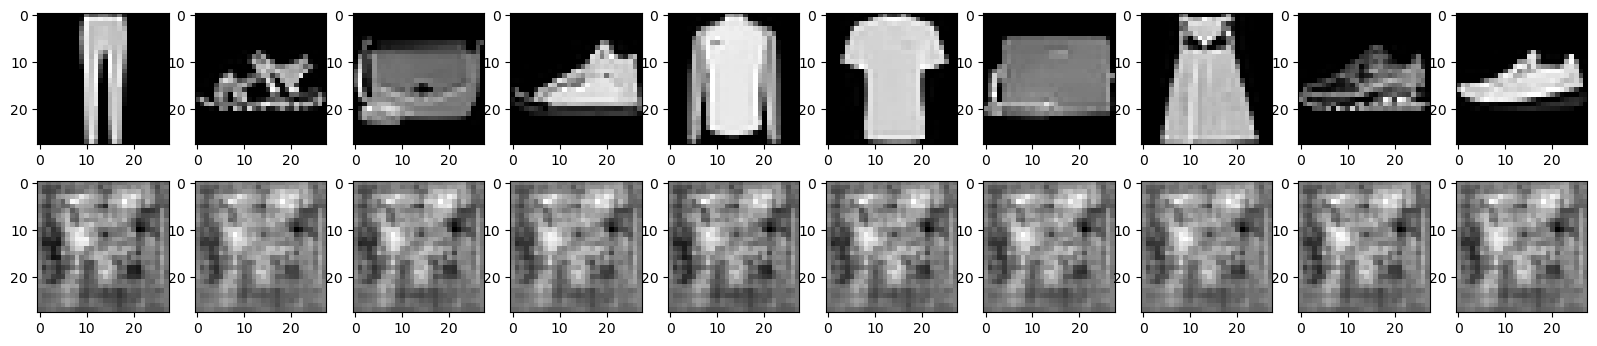

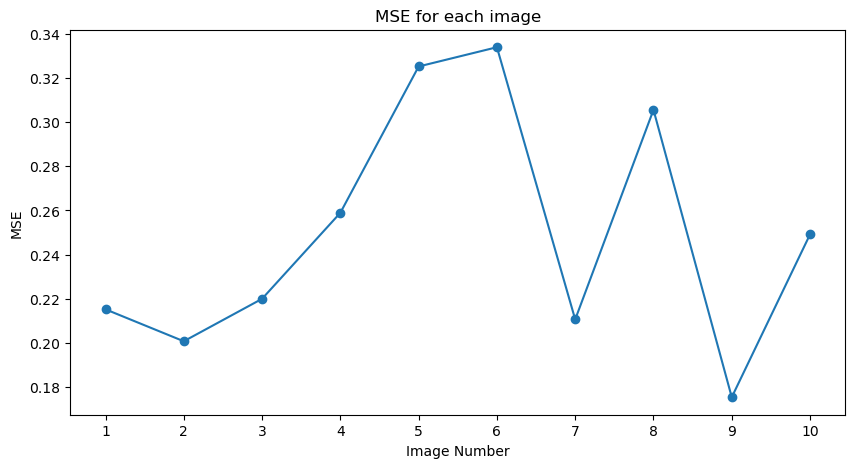

[0.21528582, 0.2008369, 0.22004758, 0.25895792, 0.32514465, 0.33386114, 0.21071267, 0.30552933, 0.17552546, 0.24919562]


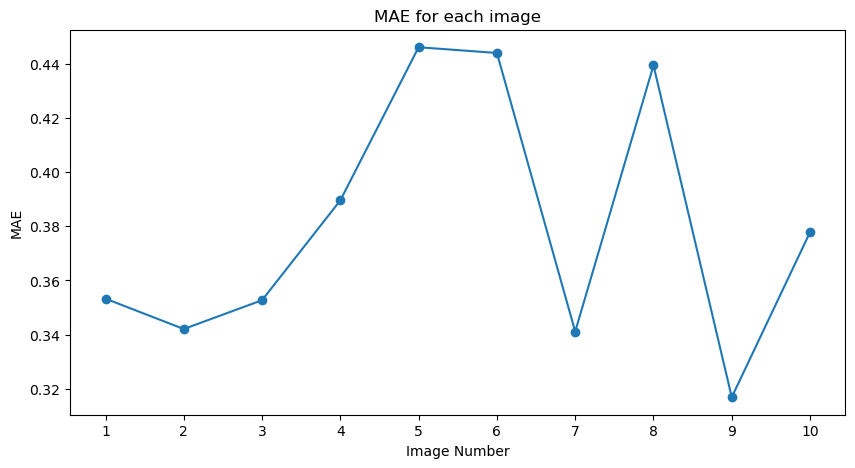

[0.3532586, 0.3420619, 0.35269862, 0.38958573, 0.4461536, 0.44402057, 0.34112528, 0.43945798, 0.31686354, 0.37782985]


In [12]:
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
tokenizer=tokenizer.to(device)
for images, _ in testloader:
    # Move the images to the device
    images = Variable(images).to(device)
    checkpoint = torch.load('/space/ankushroy/Tokeniser_FashionMNIST/vqvae_epoch10', map_location=device)
    optimizer_tokenizer.state_dict()
    
    # Pass the images through the model
    outputs = tokenizer.encode_decode(images)

    # Move the images and outputs back to the cpu
    images = images.to('cpu')
    outputs = outputs.to('cpu')

    # Convert the images and outputs to numpy arrays
    images = images.detach().numpy()
    outputs = outputs.detach().numpy()
    
     # Lists to store MSE and MAE for each image
    mse_values = []
    mae_values = []

    # Visualize the original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
    for i in range(10):
        # Display original images
        ax = axes[0, i]
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)

        # Display reconstructed images
        ax = axes[1, i]
        ax.imshow(np.squeeze(outputs[i]), cmap='gray')
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        
        # Calculate MSE and MAE for each image
        mse = np.mean((images[i] - outputs[i]) ** 2)
        mae = np.mean(np.abs(images[i] - outputs[i]))
        mse_values.append(mse)
        mae_values.append(mae)
        
    plt.show()
        
    # Plot MSE for each image
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), mse_values, marker='o')
    plt.title('MSE for each image')
    plt.xlabel('Image Number')
    plt.ylabel('MSE')
    plt.xticks(range(1, 11))
    plt.show()
    print(mse_values)

    # Plot MAE for each image
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), mae_values, marker='o')
    plt.title('MAE for each image')
    plt.xlabel('Image Number')
    plt.ylabel('MAE')
    plt.xticks(range(1, 11))
    plt.show()
    print(mae_values)    
       

    # Just visualize the first batch of the test dataset
    break


MSE for image 1: 0.011535814963281155
MAE for image 1: 0.05550576373934746
MSE for image 2: 0.016953235492110252
MAE for image 2: 0.05886984243988991
MSE for image 3: 0.02921327017247677
MAE for image 3: 0.09397169202566147
MSE for image 4: 0.03807491809129715
MAE for image 4: 0.12042292952537537
MSE for image 5: 0.009900227189064026
MAE for image 5: 0.05336130037903786
MSE for image 6: 0.007203525863587856
MAE for image 6: 0.04893702268600464
MSE for image 7: 0.015090448781847954
MAE for image 7: 0.06848516315221786
MSE for image 8: 0.007819700054824352
MAE for image 8: 0.046904485672712326
MSE for image 9: 0.016447128728032112
MAE for image 9: 0.09030129015445709
MSE for image 10: 0.011725695803761482
MAE for image 10: 0.06022048369050026


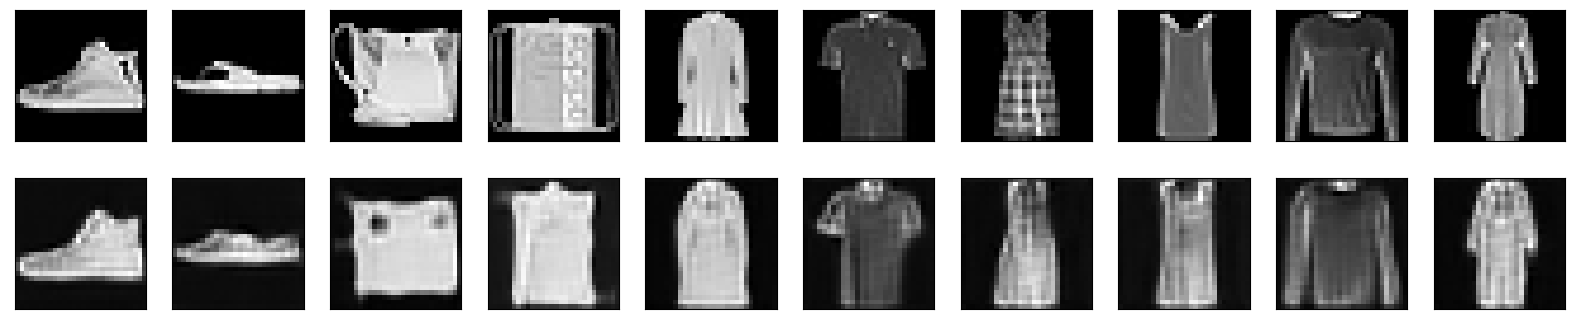

In [21]:
tokenizer=tokenizer.to(device)
for images, _ in testloader:
    # Move the images to the device
    images = images.to(device)

    # Pass the images through the model
    outputs = tokenizer.encode_decode(images)

    # Move the images and outputs back to the cpu
    images = images.to('cpu')
    outputs = outputs.to('cpu')

    # Convert the images and outputs to numpy arrays
    images = images.detach().numpy()
    outputs = outputs.detach().numpy()

    # Visualize the original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
    for i in range(10):
        # Display original images
        ax = axes[0, i]
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = axes[1, i]
        ax.imshow(np.squeeze(outputs[i]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
         # Calculate and print MSE for each image
        mse_loss = np.mean((images[i] - outputs[i]) ** 2)
        print(f"MSE for image {i+1}: {mse_loss}")
        
        # Calculate and print MAE for each image
        mae = np.mean(np.abs(images[i] - outputs[i]))
        print(f"MAE for image {i+1}: {mae}")
    plt.show()

    # Just visualize the first batch of the test dataset
    break